In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
import warnings
'''Seaborn and Matplotlib Visualization'''
import matplotlib                  # 2D Plotting Library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster
sns.set(style="darkgrid")

'''Preprocessing Learning'''
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split


In [8]:
## Define Funcitons
def ReadDF():
    sgdf=pd.read_csv("../data/listings_full.csv")# Listing from http://insideairbnb.com/ data
    df=pd.read_csv("../data/listings.csv") # Listing from Kaggle data
    # Extract features neccessary for my analysis [Cleaning fee and Cancelation policy impact Price of the properly]
    extrafeature=sgdf[['id','host_id','cancellation_policy','cleaning_fee','guests_included','bed_type','bedrooms']]
    mergedsgdata=df.merge(extrafeature,on=['id','host_id'])
    return sgdf,df,mergedsgdata

##Converting categorical features to numeric features
def Feature_conversion(df):
    '''Encode labels with value between 0 and n_classes-1.'''
    mappeddf=pd.DataFrame()
    coltochange=['neighbourhood_group','neighbourhood','room_type','bed_type','risk_rating','cancellation_policy']   
    print(coltochange)
    le = preprocessing.LabelEncoder()   
    for col in coltochange:
        #print(col)
        newcol='Name_'+col  
        mappeddf[newcol]=df[col]
        le.fit(df[col])
        df[col]=le.transform(df[col])    # normalized encoding.
        mappeddf[col]=df[col]        
    mappeddf= pd.concat([mappeddf, df[['neighbourhood_group','neighbourhood','room_type']]], axis=1, sort=False)
    print(mappeddf.head(2))
    return(mappeddf,df)

# Drop fields not significant for our future data exploration like id,host_name,name, host_id,last_review OR fill missing data
def CleanDF(raw_df): 
    dfdata=raw_df.copy()
    to_drop = ["last_review","host_name",'name','reviews_per_month'] #'id','host_id',
    # Drop selected fields in place
    dfdata.drop(to_drop, inplace=True, axis=1)  
    dfdata=dfdata.fillna(0)
    print("Original df:",dfdata.shape) 
    
    ## Remove price outliers
    df= dfdata[dfdata.price < 500 ]
    ## Remove minimum nights > 365
    df = df.drop(df[df.minimum_nights > 365].index)
    ## Remove minimum nights > 365
    df = df.drop(df[df.bedrooms > 7].index)
    print("Outlier removal:",dfdata.shape) 
    
    ## assign places as high risk based on minimum nights and number of reviews less than 1month
    mostreview = float(df[['number_of_reviews']].quantile(0.9))
    df['risk_rating'] = np.where((df['minimum_nights'] < 30) & (df['number_of_reviews'] < mostreview), 'High risk', np.where((df['minimum_nights'] < 30) & (df['number_of_reviews'] >= mostreview),                        "Medium risk", "Low risk"))    
    
    #### Fill missing values    
    # Fill bed rooms na as 0 and cnvert to int
    #print(dfdata.loc[dfdata.bedrooms==0,'room_type'].unique()) 
    df.loc[(df.bedrooms>1)&(df.room_type=='Private room'),'bedrooms' ]=1
    df.loc[(df.bedrooms>1)&(df.room_type=='Hotel room'),'bedrooms' ]=1
    df.bedrooms=df.bedrooms.astype(int)
    df.bedrooms=pd.to_numeric(df.bedrooms) 
    # Fill Cleaning Fee,remaining value to 0 
    df.cleaning_fee=df.cleaning_fee.str.replace('$','').str.replace('.00','')
    df.cleaning_fee=pd.to_numeric(df['cleaning_fee'])  
    df.cleaning_fee.fillna(0, inplace=True) 
    '''
    # Fill monthly_price remaining value to 0 
    df.monthly_price=df.monthly_price.str.replace('$','').str.replace('.00','')
    df.monthly_price=pd.to_numeric(df['monthly_price'])  
    df.monthly_price.fillna(0, inplace=True)  
    df = df.drop(df[df.monthly_price>0].index)
    #'monthly_price'
    '''
    ## review replace 0 
    df['number_of_reviews']=df['number_of_reviews'].fillna(0)  
    print(df.shape)
    return(df) 


In [9]:
# Listing from Kaggle data
sgdf,df,raw_sgdata=ReadDF() 

print(raw_sgdata.columns)
cleaneddf=CleanDF(raw_sgdata)
print(cleaneddf.dtypes)
print(cleaneddf.isna().sum().sort_values(ascending = False))

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'cancellation_policy', 'cleaning_fee',
       'guests_included', 'bed_type', 'bedrooms'],
      dtype='object')
Original df: (7323, 17)
Outlier removal: (7323, 17)
(7104, 18)
id                                  int64
host_id                             int64
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
cancellation_policy             

In [10]:
mappeddf,normaliseddf=Feature_conversion(cleaneddf)
normaliseddf.dtypes

['neighbourhood_group', 'neighbourhood', 'room_type', 'bed_type', 'risk_rating', 'cancellation_policy']
  Name_neighbourhood_group  neighbourhood_group Name_neighbourhood  \
0             North Region                    2          Woodlands   
1           Central Region                    0        Bukit Timah   

   neighbourhood Name_room_type  room_type Name_bed_type  bed_type  \
0             40   Private room          2      Real Bed         4   
1              6   Private room          2      Real Bed         4   

  Name_risk_rating  risk_rating Name_cancellation_policy  cancellation_policy  \
0         Low risk            1                 flexible                    0   
1         Low risk            1                 moderate                    1   

   neighbourhood_group  neighbourhood  room_type  
0                    2             40          2  
1                    0              6          2  


id                                  int64
host_id                             int64
neighbourhood_group                 int64
neighbourhood                       int64
latitude                          float64
longitude                         float64
room_type                           int64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
cancellation_policy                 int64
cleaning_fee                      float64
guests_included                     int64
bed_type                            int64
bedrooms                            int32
risk_rating                         int64
dtype: object

In [11]:
## ploting Data Distribution map
# ref: https://www.linkedin.com/pulse/generating-correlation-heatmaps-seaborn-python-andrew-holt
def plot_heatmap(df):
    """
    Params: df - DataFrame of our merged data
    Return: Generates a heatmap plot
    """
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10,10))
    #Generate Color Map, red & blue
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

# plot correlations
dropdf=normaliseddf.copy()
dropdf.drop(['latitude','longitude'], inplace=True,axis=1) 
dropdf = dropdf.loc[:, ~dropdf.columns.str.contains('^Unnamed')]
#plot_heatmap(dropdf)

In [12]:
dropdf.columns 


Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'room_type',
       'price', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'cancellation_policy', 'cleaning_fee', 'guests_included', 'bed_type',
       'bedrooms', 'risk_rating'],
      dtype='object')

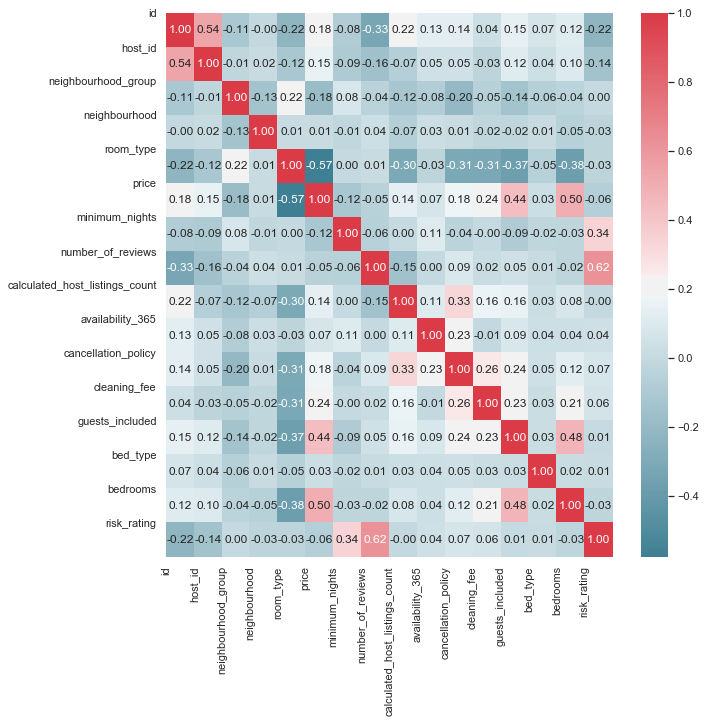

In [13]:
plot_heatmap(dropdf)

In [14]:
normaliseddf.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'cancellation_policy', 'cleaning_fee',
       'guests_included', 'bed_type', 'bedrooms', 'risk_rating'],
      dtype='object')

In [15]:
#Price is dependent on bedrooms and guest_included a
#Important features 
impfeature=['id','host_id','neighbourhood_group', 'neighbourhood','latitude','longitude','price','minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'cancellation_policy', 'guests_included',   'bedrooms', 'risk_rating']
#Non imp feature-> Remove  whose value < 0.3 in the map  
nonimpfeature=['room_type','bed_type','cleaning_fee'] ## Removed from dataframe
featurefilterdf=normaliseddf[impfeature].copy()


In [16]:
featurefilterdf.shape

(7104, 15)

In [17]:
## store data to csv
featurefilterdf.to_csv("../data/listings_clean.csv",sep="\t")
mappeddf.to_csv("../data/name_map.csv",sep="\t")